In [88]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from pytorch_tabnet.tab_model import TabNetRegressor

import optuna
import optunahub
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

import shap

import gc
gc.enable()

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

# Preprocessing & Feature Engineering

In [2]:
#from IPython.display import display as ipydisplay, HTML
#ipydisplay(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 80em; }</style>"))

In [3]:
SEED = 42
n_splits = 5

In [7]:
# path = "I:/Kaggle/child-mind-institute-problematic-internet-use/"

path = "/media/max1024/Extreme SSD/Kaggle/Data/child-mind-institute-problematic-internet-use/"

In [8]:
os.listdir(path)

['data_dictionary.csv',
 'sample_submission.csv',
 'series_test.parquet',
 'series_train.parquet',
 'test.csv',
 'train.csv']

In [9]:
train_final_df = pd.read_csv(path + 'train.csv', dtype={'id': str})
test_final_df = pd.read_csv(path + 'test.csv', dtype={'id': str})

In [10]:
print(train_final_df.shape)
train_final_df.head()

(3960, 82)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(test_final_df.shape)
test_final_df.head()

(20, 59)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
train = pd.read_csv(path + 'train.csv', dtype={'id': str})
test = pd.read_csv(path + 'test.csv', dtype={'id': str})
#sample = pd.read_csv(path + 'sample_submission.csv', dtype={'id': str})

In [13]:
data_dict = pd.read_csv(path + 'data_dictionary.csv')

In [14]:
train_target = train[test.columns]

In [15]:
concat_df = pd.concat([train_target, test], ignore_index=True)

In [16]:
concat_df['total_num_nan'] = concat_df.isna().sum(axis=1)

In [17]:
del train_target
gc.collect()

2354

In [18]:
nan_df = concat_df[concat_df['total_num_nan'] == concat_df['total_num_nan'].max()]

In [19]:
for col in concat_df.columns:
    if col == 'id':
        continue
    new_col_name = col + '_isnan'
    concat_df[new_col_name] = concat_df[col].isna().astype(int)

In [20]:
instruments = data_dict['Instrument'].unique().tolist()
instruments.remove('Identifier')

In [21]:
for instrument in instruments:
    if 'Parent-Child Internet Addiction Test' == instrument:
        continue
    instrument_df = data_dict[data_dict['Instrument'] == instrument]
    field_list = instrument_df['Field'].unique().tolist()
    concat_df[instrument + '_num_nan'] = concat_df[field_list].isna().sum(axis=1)

del instrument_df, field_list
gc.collect()

0

In [22]:
train_parquet_id_folders_list = os.listdir(path + 'series_train.parquet/')

In [23]:
train_parquet_id_list = [v.replace('id=', '') for v in train_parquet_id_folders_list]

In [24]:
test_parquet_id_folders_list = os.listdir(path + 'series_test.parquet/')

In [25]:
test_parquet_id_list = [v.replace('id=', '') for v in test_parquet_id_folders_list]

In [26]:
train_temp_df = concat_df.head(train.shape[0]).reset_index(drop=True)

In [27]:
test_temp_df = concat_df.tail(test.shape[0]).reset_index(drop=True)

In [28]:
del concat_df
gc.collect()

0

In [29]:
train_temp_df['has_parquet'] = train_temp_df['id'].isin(train_parquet_id_list).astype(int)

In [30]:
test_temp_df['has_parquet'] = test_temp_df['id'].isin(test_parquet_id_list).astype(int)

In [31]:
# https://www.kaggle.com/code/antoninadolgorukova/cmi-piu-actigraphy-data-eda
entropy = lambda x: -(x / x.sum() * np.log(x / x.sum() + 1e-9)).sum()

In [32]:
def feat_engi(df, target_cols):
    stats_df = df[target_cols].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99]).T
    count = stats_df['count'][0]
    stats_df.drop('count', axis=1, inplace=True)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    reshaped_df['count'] = count

    return reshaped_df

In [33]:
def groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)
    
    column_names_list = []
    for idx in stats_df.index:
        for col in stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))

    reshaped_df = pd.DataFrame(stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    return reshaped_df

In [34]:
def uncommon_groupby_feat_engi(df, col_to_group, target_col):
    stats_df = pd.DataFrame(
        df.groupby(col_to_group)[target_col].describe()
        #df.groupby(col_to_group)[target_col].describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    )

    stats_df['sum'] = df.groupby(col_to_group)[target_col].sum()
    stats_df['entropy'] = df.groupby(col_to_group)[target_col].apply(entropy)

    
    #stats_stats_df = stats_df.describe(percentiles=[0.01, 0.03] + [(i+1)*0.05 for i in range(19)] + [0.97, 0.99])
    stats_stats_df = stats_df.describe()
    stats_stats_count = stats_stats_df['count'][0]
    stats_stats_df.drop('count', axis=0, inplace=True)
    stats_stats_df = stats_stats_df.T
    
    column_names_list = []
    for idx in stats_stats_df.index:
        for col in stats_stats_df.columns:
            column_names_list.append(target_col + '_' + col_to_group + '_' + str(idx) + '_' + str(col))
    
    reshaped_df = pd.DataFrame(stats_stats_df.values.reshape(-1)).T.reset_index(drop=True)
    reshaped_df.columns = column_names_list

    current_cols = reshaped_df.columns.tolist()
    count_col_name = target_col + '_' + col_to_group + '_count'
    reshaped_df[count_col_name] = stats_stats_count

    reshaped_df = reshaped_df[[count_col_name] + current_cols]

    return reshaped_df

In [35]:
def read_parquet(dataset='train'):
    parquet_id_folders_list = os.listdir(path + 'series_' + dataset + '.parquet/')
    ts_list = []
    ts_features_list = []
    for id_folder in tqdm(parquet_id_folders_list):
        iid = id_folder.replace('id=', '')
    
        parquet_files_path = path + 'series_' + dataset + '.parquet/' + id_folder + '/'
        parquet_files_list = os.listdir(parquet_files_path)
    
        dfs_list = []
        for parquet_filename in parquet_files_list:
            if '.parquet' in parquet_filename:
                parquet_df = pd.read_parquet(parquet_files_path + parquet_filename)
                dfs_list.append(parquet_df)
        parquet_concat_df = pd.concat(dfs_list, ignore_index=True)
        current_cols = parquet_concat_df.columns.tolist()
        
        parquet_concat_df['id'] = iid
        
        parquet_concat_df = parquet_concat_df[['id'] + current_cols]
        
        parquet_concat_df['day_since_wear'] = (parquet_concat_df['relative_date_PCIAT'] - parquet_concat_df['relative_date_PCIAT'].min()).astype(int)
        parquet_concat_df['time_of_day_sec'] = parquet_concat_df['time_of_day'] / 1e9
        parquet_concat_df.drop('time_of_day', axis=1, inplace=True)
        parquet_concat_df['time_of_day_min'] = parquet_concat_df['time_of_day_sec'] / 60
        parquet_concat_df['time_of_day_hour'] = parquet_concat_df['time_of_day_min'] / 60
        parquet_concat_df['time_of_day_day'] = parquet_concat_df['time_of_day_hour'] / 24
        parquet_concat_df['time_of_day_hour_window'] = parquet_concat_df['time_of_day_hour'].astype(int)
        parquet_concat_df['time_of_day_min_window'] = parquet_concat_df['time_of_day_min'].astype(int)
        parquet_concat_df['time_of_day_15_min_window'] = (parquet_concat_df['time_of_day_min'] / 15).astype(int)
        parquet_concat_df['timestamp_day'] = parquet_concat_df['day_since_wear'] + parquet_concat_df['time_of_day_day']
    
        if parquet_concat_df['timestamp_day'].nunique() != parquet_concat_df.shape[0]:
            print('yes')
    
        parquet_concat_df['timestamp_hour'] = parquet_concat_df['timestamp_day'] * 24
        parquet_concat_df['timestamp_min'] = parquet_concat_df['timestamp_day'] * 24 * 60
        parquet_concat_df['timestamp_sec'] = parquet_concat_df['timestamp_day'] * 24 * 60 * 60
        parquet_concat_df['timestamp_15_min'] = parquet_concat_df['timestamp_day'] * 24 * (60/15)
    
        parquet_concat_df['timestamp_hour_window'] = parquet_concat_df['timestamp_hour'].astype(int)
        parquet_concat_df['timestamp_min_window'] = parquet_concat_df['timestamp_min'].astype(int)
        parquet_concat_df['timestamp_15_min_window'] = parquet_concat_df['timestamp_15_min'].astype(int)
    
        battery_voltage_start = parquet_concat_df['battery_voltage'][0]
        parquet_concat_df['battery_use_since_wear'] = -(parquet_concat_df['battery_voltage'] - battery_voltage_start)
        
    
        worn_df = parquet_concat_df[parquet_concat_df['non-wear_flag'] == 0].reset_index(drop=True)
    
        
        feature_cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_use_since_wear']
    
        features_df = feat_engi(worn_df, feature_cols)
    
        groupby_cols = ['weekday', 'time_of_day_hour_window']#, 'time_of_day_15_min_window']
    
        groupby_df_list = []
        for groupby_col in groupby_cols:
            for feature_col in feature_cols:
                groupby_features_df = groupby_feat_engi(worn_df, groupby_col, feature_col)
                groupby_df_list.append(groupby_features_df)
    
        groupby_concat_df = pd.concat(groupby_df_list, axis=1)
    
        uncommon_groupby_cols = ['day_since_wear', 'timestamp_hour_window']#, 'timestamp_15_min_window']#, 'timestamp_min_window']
    
        uncommon_groupby_df_list = []
        for uncommon_groupby_col in uncommon_groupby_cols:
            for unc_feature_col in feature_cols:
                uncommon_groupby_df = uncommon_groupby_feat_engi(worn_df, uncommon_groupby_col, unc_feature_col)
                uncommon_groupby_df_list.append(uncommon_groupby_df)
    
        features_concat_df = pd.concat([features_df, groupby_concat_df, uncommon_groupby_df], axis=1)
        features_current_cols = features_concat_df.columns.tolist()
        features_concat_df['id'] = iid
        features_concat_df = features_concat_df[['id'] + features_current_cols]
    
        for q in [1,2,3,4]:
            if q in worn_df['quarter'].tolist():
                features_concat_df['data_collected_in_quarter_' + str(q)] = 1
            else:
                features_concat_df['data_collected_in_quarter_' + str(q)] = 0

        features_concat_df['id'] = features_concat_df['id'].astype(str)

        #features_concat_df.to_csv(path + 'series_' + dataset + '.parquet/id=' + iid + '/features.csv', index=False)
        
        ts_list.append(parquet_concat_df)
        ts_features_list.append(features_concat_df)

        gc.collect()
    gc.collect()
    
    return ts_list, ts_features_list

In [36]:
def read_features_files():
    temp_dfs_list = []
    ts_features_folders_list = os.listdir(path + 'train_ts_features/')
    for temp_id_folder in tqdm(ts_features_folders_list):
        temp_files_list = os.listdir(path + 'train_ts_features/' + temp_id_folder + '/')
        for temp_filename in temp_files_list:
            if '.csv' in temp_filename:
                temp_df = pd.read_csv(path + 'train_ts_features/' + temp_id_folder + '/' + temp_filename, dtype={'id': str})
                temp_dfs_list.append(temp_df)
    gc.collect()
    return temp_dfs_list

In [38]:
# train_ts_features_list = read_features_files()

In [40]:
train_ts_list, train_ts_features_list = read_parquet()

100%|██████████| 996/996 [53:07<00:00,  3.20s/it] 


In [41]:
test_ts_list, test_ts_features_list = read_parquet(dataset='test')

100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


In [42]:
train_ts_features_concat_df = pd.concat(train_ts_features_list, ignore_index=True)
test_ts_features_concat_df = pd.concat(test_ts_features_list, ignore_index=True)

In [43]:
del train_ts_list, train_ts_features_list, test_ts_list, test_ts_features_list
gc.collect()

0

In [44]:
train_merge_df = train_temp_df.merge(train_ts_features_concat_df, how='left', on='id')
test_merge_df = test_temp_df.merge(test_ts_features_concat_df, how='left', on='id')

In [45]:
del train_ts_features_concat_df, test_ts_features_concat_df
gc.collect()

0

In [46]:
cat_cols = []
for i in range(data_dict.shape[0]):
    col = data_dict['Field'][i]
    if col == 'id':
        continue
    if (data_dict['Type'][i] == 'str') | ('categori' in data_dict['Type'][i]):
        cat_cols.append(col)

In [47]:
ordinal_variables = ['FGC-FGC_CU_Zone', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
                     'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
                     'PreInt_EduHx-computerinternet_hoursday']

ordinal_variables += [col for col in cat_cols if (('PCIAT' in col)&('Season' not in col))]

In [48]:
cat_cols = list(set(cat_cols) - set(ordinal_variables))
cat_cols = [col for col in cat_cols if 'PCIAT' not in col]

In [49]:
merge_concat_df = pd.concat([train_merge_df, test_merge_df], ignore_index=True)

In [50]:
del train_merge_df, test_merge_df
gc.collect()

0

In [51]:
def remove_pciat_cols(df):
    cols_to_drop = []
    for col in df.columns:
        if 'PCIAT' in col:
            cols_to_drop.append(col)

    df.drop(cols_to_drop, axis=1, inplace=True)
    
    return df

In [52]:
merge_concat_df = remove_pciat_cols(merge_concat_df)

In [53]:
def one_hot_cat_cols(df):
    for col in tqdm(cat_cols):
        df[col] = df[col].fillna('Missing').apply(str)
        unique_list = sorted(df[col].unique().tolist())

        for v in unique_list:
            new_col_name = col + '_' + v
            df[new_col_name] = (df[col] == v).astype(int)
    
    df = df.drop(cat_cols, axis=1)

    return df

In [54]:
merge_concat_df = one_hot_cat_cols(merge_concat_df)

100%|██████████| 11/11 [00:00<00:00, 151.38it/s]


In [55]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def feature_engineering(df):
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [56]:
merge_concat_df = feature_engineering(merge_concat_df)

In [57]:
no_id_cols = [col for col in merge_concat_df.columns if col != 'id']

In [58]:
if np.any(np.isinf(merge_concat_df[no_id_cols])):
    print('inf in data')
    merge_concat_df[no_id_cols] = merge_concat_df[no_id_cols].replace([np.inf, -np.inf], np.nan)

inf in data


In [59]:
imputer = KNNImputer(n_neighbors=5)
merge_concat_df[no_id_cols] = imputer.fit_transform(merge_concat_df[no_id_cols])

In [60]:
del imputer
gc.collect()

0

In [61]:
train_df = merge_concat_df.head(train.shape[0]).reset_index(drop=True)
test_df = merge_concat_df.tail(test.shape[0]).reset_index(drop=True)

In [62]:
train_df['sii'] = train['sii']

In [63]:
del train, test
gc.collect()

0

In [64]:
train_nonan_df = train_df[~train_df['sii'].isna()].reset_index(drop=True)

In [65]:
del train_df
gc.collect()

0

In [66]:
#selected_features_df = pd.read_csv(path + 'selected_features.csv')

In [67]:
#train_cols = selected_features_df['selected_features'].tolist()

In [68]:
#del selected_features_df
#gc.collect()

In [69]:
#test_cols = train_cols.copy()
#test_cols.remove('sii')

In [70]:
#train_final_df = train_nonan_df[train_cols].copy()
#test_final_df = test_df[test_cols].copy()

In [71]:
train_final_df = train_nonan_df.copy()
test_final_df = test_df.copy()

In [72]:
del train_nonan_df, test_df
gc.collect()

0

In [73]:
#selected_cols_df = pd.read_csv(path + 'selected_cols.csv')
#selected_cols_df

In [74]:
#selected_cols = selected_cols_df['col'].tolist()

In [75]:
#train_final_df = train_final_df[selected_cols + ['sii']]
#print(train_final_df.shape)
#train_final_df.head()

In [76]:
#test_final_df = test_final_df[selected_cols]
#print(test_final_df.shape)
#test_final_df.head()

In [77]:
corr_df = train_final_df.drop(['id', 'sii'], axis=1).corr()

In [78]:
# Find features with high correlation
high_corr = np.where(corr_df > 0.9)
high_corr_pairs = [
    (corr_df.index[x], corr_df.columns[y])
    for x, y in zip(*high_corr)
    if x != y and x < y
]

In [79]:
second_v_list = []
for v in high_corr_pairs:
    second_v = v[1]
    second_v_list.append(second_v)

In [80]:
redundant_features = list(set(second_v_list))

In [81]:
train_final_df = train_final_df.drop(redundant_features, axis=1)
print(train_final_df.shape)
train_final_df.head()

(2736, 1419)


,id,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,total_num_nan,Basic_Demos-Enroll_Season_isnan,Basic_Demos-Age_isnan,Basic_Demos-Sex_isnan,CGAS-Season_isnan,Physical-Season_isnan,Physical-BMI_isnan,Physical-Waist_Circumference_isnan,Physical-Diastolic_BP_isnan,Fitness_Endurance-Season_isnan,Fitness_Endurance-Max_Stage_isnan,FGC-Season_isnan,FGC-FGC_CU_isnan,FGC-FGC_GSND_isnan,BIA-Season_isnan,PAQ_A-Season_isnan,PAQ_C-Season_isnan,SDS-Season_isnan,PreInt_EduHx-Season_isnan,PreInt_EduHx-computerinternet_hoursday_isnan,total_num_nan_isnan,Demographics_num_nan,has_parquet,X_mean,X_std,X_min,X_1%,X_99%,X_max,Y_mean,Y_std,Y_min,Y_1%,Y_3%,Y_95%,Y_99%,Y_max,Z_mean,Z_std,Z_min,Z_1%,Z_3%,Z_99%,Z_max,enmo_mean,enmo_std,enmo_min,enmo_1%,enmo_10%,enmo_max,anglez_min,anglez_1%,anglez_max,light_mean,light_min,light_1%,light_10%,light_max,battery_use_since_wear_mean,battery_use_since_wear_std,battery_use_since_wear_min,battery_use_since_wear_1%,battery_use_since_wear_3%,battery_use_since_wear_10%,battery_use_since_wear_max,count,X_weekday_1_mean,X_weekday_1_std,X_weekday_1_min,X_weekday_1_1%,X_weekday_1_max,X_weekday_1_sum,X_weekday_1_entropy,X_weekday_2_mean,X_weekday_2_std,X_weekday_2_min,X_weekday_2_1%,X_weekday_2_max,X_weekday_2_sum,X_weekday_2_entropy,X_weekday_3_mean,X_weekday_3_std,X_weekday_3_min,X_weekday_3_1%,X_weekday_3_3%,X_weekday_3_max,X_weekday_3_sum,X_weekday_3_entropy,X_weekday_4_mean,X_weekday_4_std,X_weekday_4_min,X_weekday_4_1%,X_weekday_4_max,X_weekday_4_sum,X_weekday_4_entropy,X_weekday_5_mean,X_weekday_5_std,X_weekday_5_min,X_weekday_5_1%,X_weekday_5_max,X_weekday_5_sum,X_weekday_5_entropy,X_weekday_6_mean,X_weekday_6_std,X_weekday_6_min,X_weekday_6_1%,X_weekday_6_max,X_weekday_6_sum,X_weekday_6_entropy,X_weekday_7_mean,X_weekday_7_std,X_weekday_7_min,X_weekday_7_1%,X_weekday_7_max,X_weekday_7_sum,X_weekday_7_entropy,Y_weekday_1_mean,Y_weekday_1_std,Y_weekday_1_min,Y_weekday_1_1%,Y_weekday_1_max,Y_weekday_1_sum,Y_weekday_1_entropy,Y_weekday_2_mean,Y_weekday_2_std,Y_weekday_2_min,Y_weekday_2_1%,Y_weekday_2_max,Y_weekday_2_sum,Y_weekday_2_entropy,Y_weekday_3_mean,Y_weekday_3_std,Y_weekday_3_min,Y_weekday_3_1%,Y_weekday_3_max,Y_weekday_3_sum,Y_weekday_3_entropy,Y_weekday_4_mean,Y_weekday_4_std,Y_weekday_4_min,Y_weekday_4_1%,Y_weekday_4_max,Y_weekday_4_sum,Y_weekday_4_entropy,Y_weekday_5_mean,Y_weekday_5_std,Y_weekday_5_min,Y_weekday_5_1%,Y_weekday_5_70%,Y_weekday_5_max,Y_weekday_5_sum,Y_weekday_5_entropy,Y_weekday_6_mean,Y_weekday_6_std,Y_weekday_6_min,Y_weekday_6_1%,Y_weekday_6_max,Y_weekday_6_sum,Y_weekday_6_entropy,Y_weekday_7_mean,Y_weekday_7_std,Y_weekday_7_min,Y_weekday_7_1%,Y_weekday_7_max,Y_weekday_7_sum,Y_weekday_7_entropy,Z_weekday_1_mean,Z_weekday_1_std,Z_weekday_1_min,Z_weekday_1_15%,Z_weekday_1_max,Z_weekday_1_sum,Z_weekday_1_entropy,Z_weekday_2_mean,Z_weekday_2_std,Z_weekday_2_min,Z_weekday_2_1%,Z_weekday_2_3%,Z_weekday_2_15%,Z_weekday_2_90%,Z_weekday_2_max,Z_weekday_2_sum,Z_weekday_2_entropy,Z_weekday_3_mean,Z_weekday_3_std,Z_weekday_3_min,Z_weekday_3_1%,Z_weekday_3_max,Z_weekday_3_sum,Z_weekday_3_entropy,Z_weekday_4_mean,Z_weekday_4_std,Z_weekday_4_min,Z_weekday_4_1%,Z_weekday_4_25%,Z_weekday_4_max,Z_weekday_4_sum,Z_weekday_4_entropy,Z_weekday_5_mean,Z_weekday_5_std,Z_weekday_5_min,Z_weekday_5_1%,Z_weekday_5_max,Z_weekday_5_sum,Z_weekday_5_entropy,Z_weekday_6_mean,Z_weekday_6_std,Z_weekday_6_min,Z_weekday_6_95%,Z_weekday_6_max

In [82]:
test_final_df = test_final_df.drop(redundant_features, axis=1)
print(test_final_df.shape)
test_final_df.head()

(20, 1418)


,id,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,PAQ_A-PAQ_A_Total,PAQ_C-PAQ_C_Total,SDS-SDS_Total_Raw,PreInt_EduHx-computerinternet_hoursday,total_num_nan,Basic_Demos-Enroll_Season_isnan,Basic_Demos-Age_isnan,Basic_Demos-Sex_isnan,CGAS-Season_isnan,Physical-Season_isnan,Physical-BMI_isnan,Physical-Waist_Circumference_isnan,Physical-Diastolic_BP_isnan,Fitness_Endurance-Season_isnan,Fitness_Endurance-Max_Stage_isnan,FGC-Season_isnan,FGC-FGC_CU_isnan,FGC-FGC_GSND_isnan,BIA-Season_isnan,PAQ_A-Season_isnan,PAQ_C-Season_isnan,SDS-Season_isnan,PreInt_EduHx-Season_isnan,PreInt_EduHx-computerinternet_hoursday_isnan,total_num_nan_isnan,Demographics_num_nan,has_parquet,X_mean,X_std,X_min,X_1%,X_99%,X_max,Y_mean,Y_std,Y_min,Y_1%,Y_3%,Y_95%,Y_99%,Y_max,Z_mean,Z_std,Z_min,Z_1%,Z_3%,Z_99%,Z_max,enmo_mean,enmo_std,enmo_min,enmo_1%,enmo_10%,enmo_max,anglez_min,anglez_1%,anglez_max,light_mean,light_min,light_1%,light_10%,light_max,battery_use_since_wear_mean,battery_use_since_wear_std,battery_use_since_wear_min,battery_use_since_wear_1%,battery_use_since_wear_3%,battery_use_since_wear_10%,battery_use_since_wear_max,count,X_weekday_1_mean,X_weekday_1_std,X_weekday_1_min,X_weekday_1_1%,X_weekday_1_max,X_weekday_1_sum,X_weekday_1_entropy,X_weekday_2_mean,X_weekday_2_std,X_weekday_2_min,X_weekday_2_1%,X_weekday_2_max,X_weekday_2_sum,X_weekday_2_entropy,X_weekday_3_mean,X_weekday_3_std,X_weekday_3_min,X_weekday_3_1%,X_weekday_3_3%,X_weekday_3_max,X_weekday_3_sum,X_weekday_3_entropy,X_weekday_4_mean,X_weekday_4_std,X_weekday_4_min,X_weekday_4_1%,X_weekday_4_max,X_weekday_4_sum,X_weekday_4_entropy,X_weekday_5_mean,X_weekday_5_std,X_weekday_5_min,X_weekday_5_1%,X_weekday_5_max,X_weekday_5_sum,X_weekday_5_entropy,X_weekday_6_mean,X_weekday_6_std,X_weekday_6_min,X_weekday_6_1%,X_weekday_6_max,X_weekday_6_sum,X_weekday_6_entropy,X_weekday_7_mean,X_weekday_7_std,X_weekday_7_min,X_weekday_7_1%,X_weekday_7_max,X_weekday_7_sum,X_weekday_7_entropy,Y_weekday_1_mean,Y_weekday_1_std,Y_weekday_1_min,Y_weekday_1_1%,Y_weekday_1_max,Y_weekday_1_sum,Y_weekday_1_entropy,Y_weekday_2_mean,Y_weekday_2_std,Y_weekday_2_min,Y_weekday_2_1%,Y_weekday_2_max,Y_weekday_2_sum,Y_weekday_2_entropy,Y_weekday_3_mean,Y_weekday_3_std,Y_weekday_3_min,Y_weekday_3_1%,Y_weekday_3_max,Y_weekday_3_sum,Y_weekday_3_entropy,Y_weekday_4_mean,Y_weekday_4_std,Y_weekday_4_min,Y_weekday_4_1%,Y_weekday_4_max,Y_weekday_4_sum,Y_weekday_4_entropy,Y_weekday_5_mean,Y_weekday_5_std,Y_weekday_5_min,Y_weekday_5_1%,Y_weekday_5_70%,Y_weekday_5_max,Y_weekday_5_sum,Y_weekday_5_entropy,Y_weekday_6_mean,Y_weekday_6_std,Y_weekday_6_min,Y_weekday_6_1%,Y_weekday_6_max,Y_weekday_6_sum,Y_weekday_6_entropy,Y_weekday_7_mean,Y_weekday_7_std,Y_weekday_7_min,Y_weekday_7_1%,Y_weekday_7_max,Y_weekday_7_sum,Y_weekday_7_entropy,Z_weekday_1_mean,Z_weekday_1_std,Z_weekday_1_min,Z_weekday_1_15%,Z_weekday_1_max,Z_weekday_1_sum,Z_weekday_1_entropy,Z_weekday_2_mean,Z_weekday_2_std,Z_weekday_2_min,Z_weekday_2_1%,Z_weekday_2_3%,Z_weekday_2_15%,Z_weekday_2_90%,Z_weekday_2_max,Z_weekday_2_sum,Z_weekday_2_entropy,Z_weekday_3_mean,Z_weekday_3_std,Z_weekday_3_min,Z_weekday_3_1%,Z_weekday_3_max,Z_weekday_3_sum,Z_weekday_3_entropy,Z_weekday_4_mean,Z_weekday_4_std,Z_weekday_4_min,Z_weekday_4_1%,Z_weekday_4_25%,Z_weekday_4_max,Z_weekday_4_sum,Z_weekday_4_entropy,Z_weekday_5_mean,Z_weekday_5_std,Z_weekday_5_min,Z_weekday_5_1%,Z_weekday_5_max,Z_weekday_5_sum,Z_weekday_5_entropy,Z_weekday_6_mean,Z_weekday_6_std,Z_weekday_6_min,Z_weekday_6_95%,Z_weekday_6_max

# Parameter tuning, training, prediction & submission

In [83]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [89]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def xgb_param_tune(train_data, test_data, optuna_n_trials):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True)#, random_state=SEED)
    
    train_S = []
    test_S = []
     
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    base_params = {
        #'random_state': SEED,
        'tree_method': 'gpu_hist',
        'n_estimators': 3000,
        'verbosity': 0
    }

    writer = SummaryWriter("kaggle/childmind/runs/20241218_03_xgb_param_tune")

    def objective(trial):

        oof_non_rounded = np.zeros(len(y), dtype=float)
        
        params_to_tune = {            
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.7),
            'max_depth': trial.suggest_int('max_depth', 6, 20),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 2000),
            'min_child_weight': trial.suggest_float('min_child_weight', 0, 100),
            'min_split_loss': trial.suggest_float('min_split_loss', 0, 20),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50),
        }
    
        #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

            
            model = XGBRegressor(
                **base_params,
                **params_to_tune
            )
            
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)#, plot=True)
    
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
    
            oof_non_rounded[test_idx] = y_val_pred
            y_val_pred_rounded = y_val_pred.round(0).astype(int)
            oof_rounded[test_idx] = y_val_pred_rounded

        # https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/551533
        y_preds_df = pd.DataFrame({'y':y, 'preds':oof_non_rounded})
        oof_initial_thresholds = y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()
    
        KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=oof_initial_thresholds, args=(y, oof_non_rounded), 
                                  method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."
        
        oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, oof_tuned)

        del y_preds_df, oof_initial_thresholds
        gc.collect()
    
        return tKappa

    with tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial") as pbar:
        
        # Define a callback function to update the progress bar
        def progress_bar_callback(study, trial):
            pbar.update(1)
    
        study = optuna.create_study(
            direction="maximize",
            sampler=optunahub.load_module("samplers/auto_sampler").AutoSampler(),
            storage="sqlite:////home/max1024/Kaggle/childmind/optuna_study/db.sqlite3",
            study_name="childmind_xgb_param_tune_20241218_03"
        )
        study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

    best_params = study.best_params

    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []
    shap_importance_list = []

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = XGBRegressor(
            **base_params,
            **best_params
        )
        
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=0)#, plot=True)

        plt.figure(figsize=(10, 6))

        eval_results = model.evals_result_

        # Extract metrics
        try:
            train_rmse = eval_results['validation_0']['rmse']
            val_rmse = eval_results['validation_1']['rmse']
            plt.plot(train_rmse, label='Training RMSE')
            plt.plot(val_rmse, label='Validation RMSE')
            plt.ylabel('RMSE')
            plt.title('Training vs Validation RMSE')
        except:
            train_mphe = eval_results['validation_0']['mphe']
            val_mphe = eval_results['validation_1']['mphe']
            plt.plot(train_mphe, label='Training mphe')
            plt.plot(val_mphe, label='Validation mphe')
            plt.ylabel('mphe')
            plt.title('Training vs Validation mphe')
        
        # Plot the results
        plt.xlabel('Boosting Rounds')
        plt.legend()
        plt.grid(True)
        plt.show()

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_y_preds_df = pd.DataFrame({'y':y_train, 'preds':y_train_pred})
        train_oof_initial_thresholds = train_y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=train_oof_initial_thresholds, args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_y_preds_df = pd.DataFrame({'y':y_val, 'preds':y_val_pred})
        val_oof_initial_thresholds = val_y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=val_oof_initial_thresholds, args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X=X_val, y=y_val)
        shap_importance = np.abs(shap_values).mean(axis=0)

        shap_importance_list.append(shap_importance)

        

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    y_preds_df = pd.DataFrame({'y':y, 'preds':oof_non_rounded})
    oof_initial_thresholds = y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=oof_initial_thresholds, args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm, study, np.mean(shap_importance_list, axis=0)

Optimizing: 100%|██████████| 300/300 [2:21:54<00:00, 28.38s/trial]   


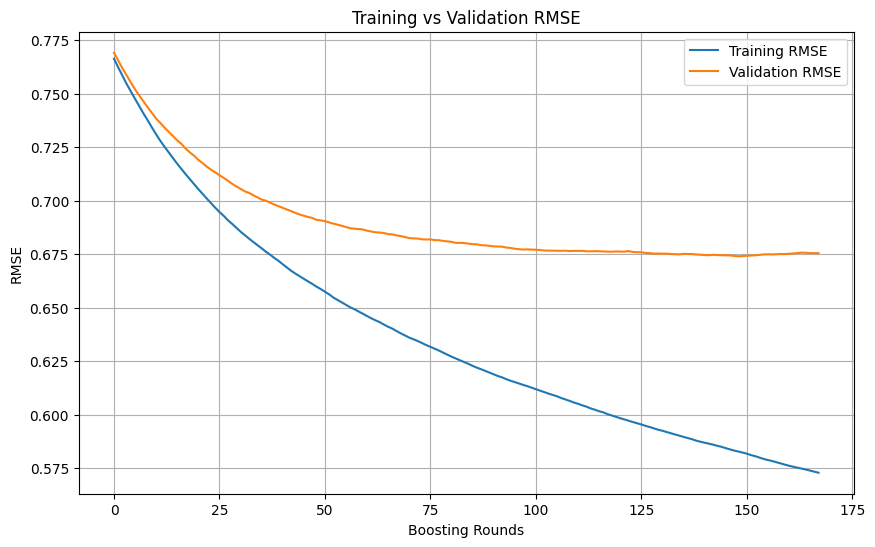

----> || Train Optimized QWK SCORE ::  0.672
----> || Val Optimized QWK SCORE ::  0.458
----> || Train Optimized Val QWK SCORE ::  0.454
----> || Val Optimized Train QWK SCORE ::  0.643
Fold 1 - Rounded Train QWK: 0.5310, Rounded Validation QWK: 0.3568


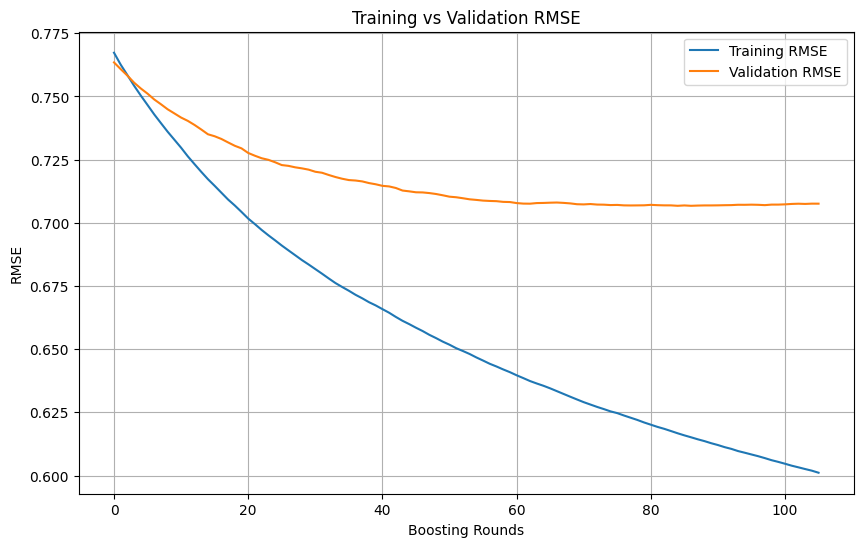

----> || Train Optimized QWK SCORE ::  0.625
----> || Val Optimized QWK SCORE ::  0.354
----> || Train Optimized Val QWK SCORE ::  0.348
----> || Val Optimized Train QWK SCORE ::  0.581
Fold 2 - Rounded Train QWK: 0.4654, Rounded Validation QWK: 0.2814


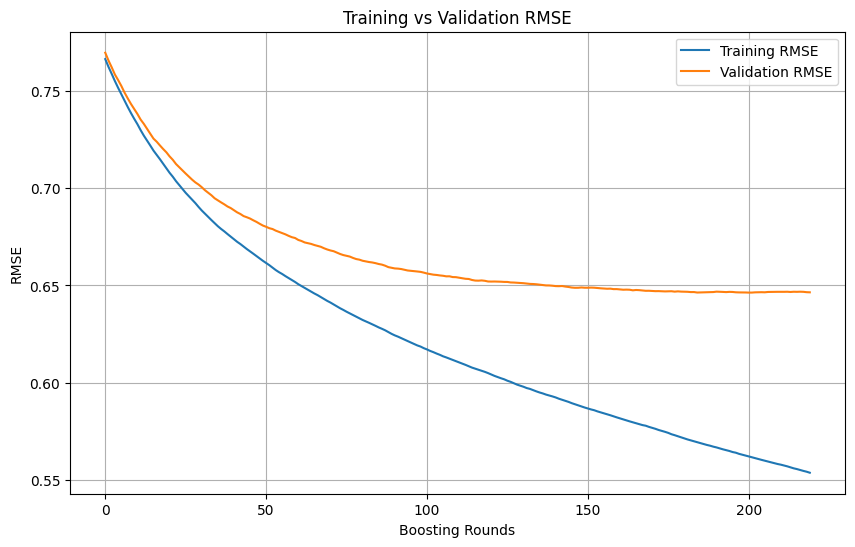

----> || Train Optimized QWK SCORE ::  0.712
----> || Val Optimized QWK SCORE ::  0.541
----> || Train Optimized Val QWK SCORE ::  0.540
----> || Val Optimized Train QWK SCORE ::  0.658
Fold 3 - Rounded Train QWK: 0.5644, Rounded Validation QWK: 0.4001


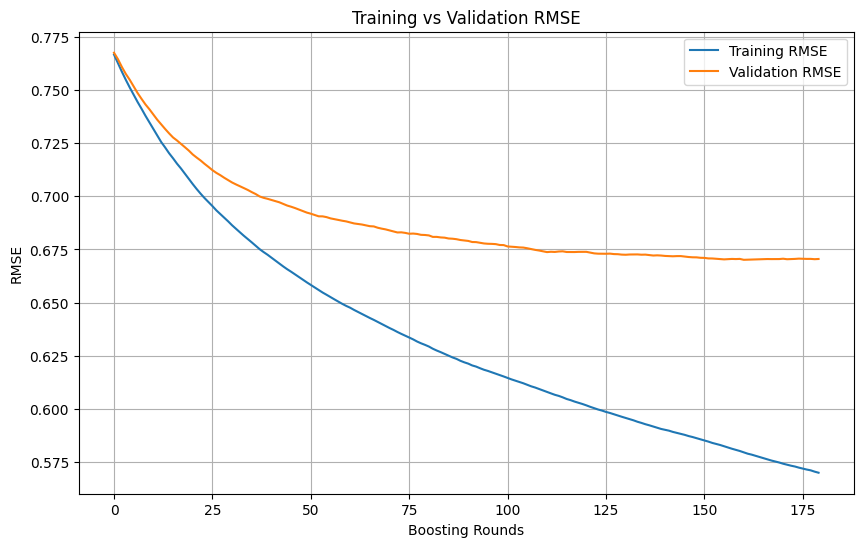

----> || Train Optimized QWK SCORE ::  0.680
----> || Val Optimized QWK SCORE ::  0.480
----> || Train Optimized Val QWK SCORE ::  0.463
----> || Val Optimized Train QWK SCORE ::  0.650
Fold 4 - Rounded Train QWK: 0.5296, Rounded Validation QWK: 0.3530


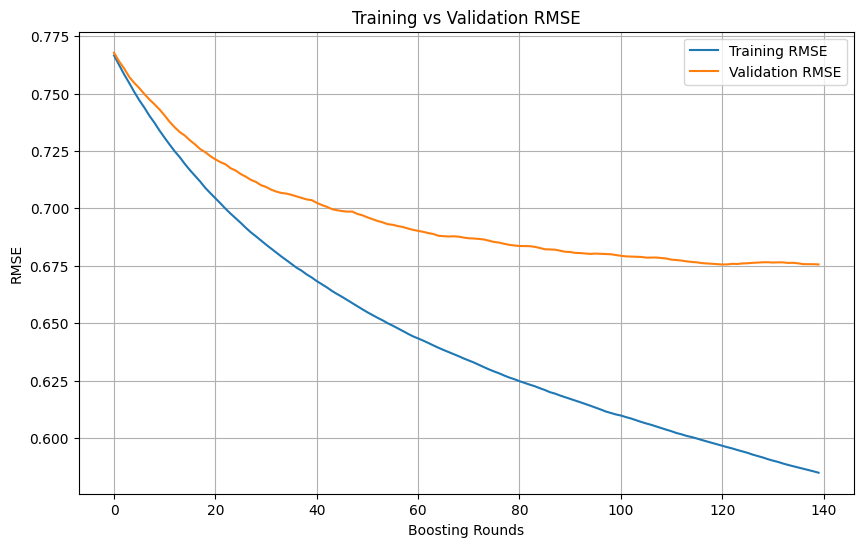

----> || Train Optimized QWK SCORE ::  0.663
----> || Val Optimized QWK SCORE ::  0.501
----> || Train Optimized Val QWK SCORE ::  0.462
----> || Val Optimized Train QWK SCORE ::  0.621
Fold 5 - Rounded Train QWK: 0.4817, Rounded Validation QWK: 0.3466
Mean Train QWK --> 0.6705
Mean Validation QWK ---> 0.4669
----> || Optimized QWK SCORE ::  0.467


In [90]:
xgb_models_list, xgb_submission_df, xgb_raw_train_preds, xgb_raw_test_preds, xgb_optuna_study, xgb_shap_importance = xgb_param_tune(
    train_final_df, test_final_df, 300
)

In [91]:
cols = train_final_df.drop(['id', 'sii'], axis=1).columns
imp_df = pd.DataFrame(sorted(zip(cols, xgb_shap_importance)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [92]:
imp_df

,Feature,Importance
91,PreInt_EduHx-computerinternet_hoursday,0.092205
93,SDS-SDS_Total_Raw,0.084209
12,Basic_Demos-Age,0.081288
80,Physical-Height,0.056877
19,Basic_Demos-Sex_0,0.030801
...,...,...
1379,light_weekday_2_std,0.000000
24,CGAS-Season_Spring,0.000000
1398,light_weekday_5_75%,0.000000
7,BIA-Season_Fall,0.000000


<Axes: xlabel='Importance', ylabel='Feature'>

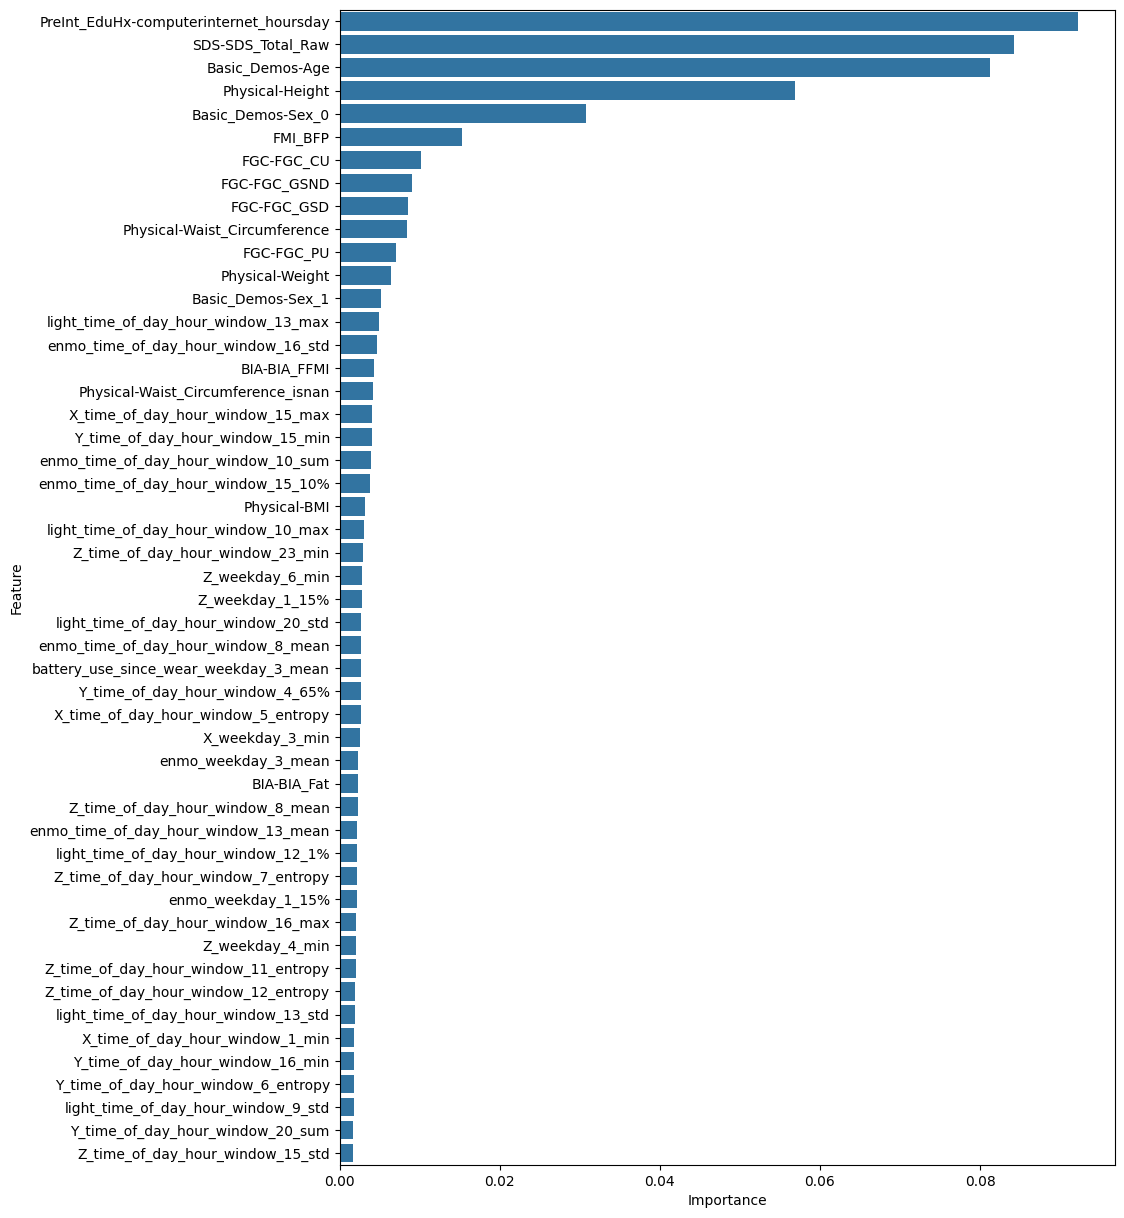

In [101]:
plt.figure(figsize=(10, 15))
sns.barplot(x=imp_df['Importance'][:50], y=imp_df['Feature'][:50])

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def catboost_param_tune(train_data, test_data, optuna_n_trials):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
     
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    base_params = {
        'iterations': 1500,
        'random_seed': SEED,
        'verbose': 0,
        'task_type': 'GPU',
        'use_best_model': True,
        'boosting_type': 'Plain'
    }

    def objective(trial):

        oof_non_rounded = np.zeros(len(y), dtype=float)
        
        params_to_tune = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.7),
            'depth': trial.suggest_int('depth', 6, 8),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 2000),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 70),
            #'border_count': trial.suggest_int('border_count', 64, 512),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 2),
            'random_strength': trial.suggest_float('random_strength', 0, 20)
        }
    
        #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
            model = CatBoostRegressor(
                **base_params,
                **params_to_tune
            )
            
            model.fit(X_train, y_train, eval_set=(X_val, y_val))#, plot=True)
    
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
    
            oof_non_rounded[test_idx] = y_val_pred
            y_val_pred_rounded = y_val_pred.round(0).astype(int)
            oof_rounded[test_idx] = y_val_pred_rounded

        # https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/551533
        y_preds_df = pd.DataFrame({'y':y, 'preds':oof_non_rounded})
        oof_initial_thresholds = y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()
    
        KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=oof_initial_thresholds, args=(y, oof_non_rounded), 
                                  method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."
        
        oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, oof_tuned)

        del y_preds_df, oof_initial_thresholds
        gc.collect()
    
        return tKappa

    with tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial") as pbar:
        
        # Define a callback function to update the progress bar
        def progress_bar_callback(study, trial):
            pbar.update(1)
    
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

    best_params = study.best_params

    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []
    shap_importance_list = []

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostRegressor(
            **base_params,
            **best_params
        )
        
        model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_y_preds_df = pd.DataFrame({'y':y_train, 'preds':y_train_pred})
        train_oof_initial_thresholds = train_y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=train_oof_initial_thresholds, args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_y_preds_df = pd.DataFrame({'y':y_val, 'preds':y_val_pred})
        val_oof_initial_thresholds = val_y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=val_oof_initial_thresholds, args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X=X_val, y=y_val)
        shap_importance = np.abs(shap_values).mean(axis=0)

        shap_importance_list.append(shap_importance)

        

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    y_preds_df = pd.DataFrame({'y':y, 'preds':oof_non_rounded})
    oof_initial_thresholds = y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=oof_initial_thresholds, args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm, study, np.mean(shap_importance_list, axis=0)

In [ ]:
cat_models_list, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds, cat_optuna_study, cat_shap_importance = catboost_param_tune(
    train_final_df, test_final_df, 300
)

In [ ]:
for param in cat_optuna_study.best_params.keys():
    fig = plot_slice(cat_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(cat_optuna_study)

In [ ]:
cat_optuna_study.best_params

In [ ]:
cols = train_final_df.drop(['id', 'sii'], axis=1).columns
imp_df = pd.DataFrame(sorted(zip(cols, cat_shap_importance)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.5)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df = train_final_df.drop(unimportant_cols, axis=1)
print(train_selected_df.shape)
train_selected_df.head()

In [ ]:
test_selected_df = test_final_df.drop(unimportant_cols, axis=1)
print(test_selected_df.shape)
test_selected_df.head()

In [ ]:
cat_models_list2, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds, cat_optuna_study, cat_shap_importance2 = catboost_param_tune(
    train_selected_df, test_selected_df, 300
)

In [ ]:
for param in cat_optuna_study.best_params.keys():
    fig = plot_slice(cat_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(cat_optuna_study)

In [ ]:
cat_optuna_study.best_params

In [ ]:
cols = train_selected_df.drop(['id', 'sii'], axis=1).columns
imp_df = pd.DataFrame(sorted(zip(cols, cat_shap_importance2)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df3 = train_selected_df.drop(unimportant_cols, axis=1)
print(train_selected_df3.shape)
train_selected_df3.head()

In [ ]:
test_selected_df3 = test_selected_df.drop(unimportant_cols, axis=1)
print(test_selected_df3.shape)
test_selected_df3.head()

In [ ]:
cat_models_list3, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds, cat_optuna_study, cat_shap_importance3 = catboost_param_tune(
    train_selected_df3, test_selected_df3, 300
)

In [ ]:
for param in cat_optuna_study.best_params.keys():
    fig = plot_slice(cat_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(cat_optuna_study)

In [ ]:
cat_optuna_study.best_params

In [ ]:
cols = train_selected_df3.drop(['id', 'sii'], axis=1).columns
imp_df = pd.DataFrame(sorted(zip(cols, cat_shap_importance3)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df4 = train_selected_df3.drop(unimportant_cols, axis=1)
print(train_selected_df4.shape)
train_selected_df4.head()

In [ ]:
test_selected_df4 = test_selected_df3.drop(unimportant_cols, axis=1)
print(test_selected_df4.shape)
test_selected_df4.head()

In [ ]:
cat_models_list4, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds, cat_optuna_study, cat_shap_importance4 = catboost_param_tune(
    train_selected_df4, test_selected_df4, 300
)

In [ ]:
for param in cat_optuna_study.best_params.keys():
    fig = plot_slice(cat_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(cat_optuna_study)

In [ ]:
cat_optuna_study.best_params

In [ ]:
cols = train_selected_df4.drop(['id', 'sii'], axis=1).columns
imp_df = pd.DataFrame(sorted(zip(cols, cat_shap_importance4)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df5 = train_selected_df4.drop(unimportant_cols, axis=1)
print(train_selected_df5.shape)
train_selected_df5.head()

In [ ]:
test_selected_df5 = test_selected_df4.drop(unimportant_cols, axis=1)
print(test_selected_df5.shape)
test_selected_df5.head()

In [ ]:
cat_models_list5, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds, cat_optuna_study, cat_shap_importance5 = catboost_param_tune(
    train_selected_df5, test_selected_df5, 250
)

In [ ]:
for param in cat_optuna_study.best_params.keys():
    fig = plot_slice(cat_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(cat_optuna_study)

In [ ]:
cat_optuna_study.best_params

In [ ]:
cols = train_selected_df5.drop(['id', 'sii'], axis=1).columns
imp_df = pd.DataFrame(sorted(zip(cols, cat_shap_importance5)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df6 = train_selected_df5.drop(unimportant_cols, axis=1)
print(train_selected_df6.shape)
train_selected_df6.head()

In [ ]:
test_selected_df6 = test_selected_df5.drop(unimportant_cols, axis=1)
print(test_selected_df6.shape)
test_selected_df6.head()

In [ ]:
cat_models_list6, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds, cat_optuna_study, cat_shap_importance6 = catboost_param_tune(
    train_selected_df6, test_selected_df6, 300
)

In [ ]:
for param in cat_optuna_study.best_params.keys():
    fig = plot_slice(cat_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(cat_optuna_study)

In [ ]:
cat_optuna_study.best_params

In [ ]:
cols = train_selected_df6.drop(['id', 'sii'], axis=1).columns
imp_df = pd.DataFrame(sorted(zip(cols, cat_shap_importance6)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df7 = train_selected_df6.drop(unimportant_cols, axis=1)
print(train_selected_df7.shape)
train_selected_df7.head()

In [ ]:
test_selected_df7 = test_selected_df6.drop(unimportant_cols, axis=1)
print(test_selected_df7.shape)
test_selected_df7.head()

In [ ]:
cat_models_list7, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds, cat_optuna_study, cat_shap_importance7 = catboost_param_tune(
    train_selected_df7, test_selected_df7, 300
)

In [ ]:
for param in cat_optuna_study.best_params.keys():
    fig = plot_slice(cat_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(cat_optuna_study)

In [ ]:
cat_optuna_study.best_params

In [ ]:
cols = train_selected_df7.drop(['id', 'sii'], axis=1).columns
imp_df = pd.DataFrame(sorted(zip(cols, cat_shap_importance7)), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
unimportant_df = imp_df[imp_df['Importance'] <= imp_df['Importance'].quantile(0.1)]
unimportant_cols = unimportant_df['Feature'].tolist()

In [ ]:
train_selected_df8 = train_selected_df7.drop(unimportant_cols, axis=1)
print(train_selected_df8.shape)
train_selected_df8.head()

In [ ]:
test_selected_df8 = test_selected_df7.drop(unimportant_cols, axis=1)
print(test_selected_df8.shape)
test_selected_df8.head()

In [ ]:
train_selected_df7.to_csv(path + 'cat_train_selected_7.csv', index=False)

In [ ]:
test_selected_df7.to_csv(path + 'cat_test_selected_7.csv', index=False)

In [ ]:
train_selected_df8.to_csv(path + 'cat_train_selected_8.csv', index=False)

In [ ]:
test_selected_df8.to_csv(path + 'cat_test_selected_8.csv', index=False)

In [ ]:
cat_models_list8, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds, cat_optuna_study, cat_shap_importance8 = catboost_param_tune(
    train_selected_df8, test_selected_df8, 300
)

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)

def lgb_feature_selection(train_data, test_data, optuna_n_trials):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    base_params = {
        'verbosity': -1,
        'seed': SEED,
        'num_iterations': 10000,
        'feature_fraction': 0.8,
        'device': 'gpu'
    }

    def objective(trial):

        params_to_tune = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'early_stopping_round': trial.suggest_int('early_stopping_round', 10, 70),
            'max_depth': trial.suggest_int('max_depth', 6, 50),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 300),
            'num_leaves': trial.suggest_int('num_leaves', 50, 10000),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 0.3),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
            'lambda_l2': trial.suggest_float('lambda_l2', 50, 2000)
        }

        #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
            
            lgb_callbacks = [
                lgb.log_evaluation(period=20)
            ]
    
            model = LGBMRegressor(
                **base_params,
                **params_to_tune
            )
            
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)
    
            #plt.figure()
            #lgb.plot_metric(model)
            #plt.show()
            
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
    
            oof_non_rounded[test_idx] = y_val_pred
            y_val_pred_rounded = y_val_pred.round(0).astype(int)
            oof_rounded[test_idx] = y_val_pred_rounded
    
        #print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
        #print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

        # https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/discussion/551533
        y_preds_df = pd.DataFrame({'y':y, 'preds':oof_non_rounded})
        oof_initial_thresholds = y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()
    
        KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=oof_initial_thresholds, args=(y, oof_non_rounded), 
                                  method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."

        del y_preds_df, oof_initial_thresholds
        gc.collect()
        
        oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, oof_tuned)
    
        #print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")
    
        return tKappa

    with tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial") as pbar:
        
        # Define a callback function to update the progress bar
        def progress_bar_callback(study, trial):
            pbar.update(1)
    
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

    best_params = study.best_params

    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_callbacks = [
            lgb.log_evaluation(period=20)
        ]

        model = LGBMRegressor(
            **base_params,
            **best_params
        )
        
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)

        plt.figure()
        lgb.plot_metric(model)
        plt.show()
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_y_preds_df = pd.DataFrame({'y':y_train, 'preds':y_train_pred})
        train_oof_initial_thresholds = train_y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=train_oof_initial_thresholds, args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_y_preds_df = pd.DataFrame({'y':y_val, 'preds':y_val_pred})
        val_oof_initial_thresholds = val_y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=val_oof_initial_thresholds, args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    y_preds_df = pd.DataFrame({'y':y, 'preds':oof_non_rounded})
    oof_initial_thresholds = y_preds_df.groupby('y')['preds'].mean().iloc[1:].values.tolist()

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=oof_initial_thresholds, args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm, study

In [ ]:
lgb_models_list, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(train_final_df, test_final_df, 300)

In [ ]:
for param in lgb_optuna_study.best_params.keys():
    fig = plot_slice(lgb_optuna_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(lgb_optuna_study)

In [ ]:
print(train_final_df.shape)
train_final_df.head()

In [ ]:
selected_cols = train_final_df.columns.tolist()

In [ ]:
selected_cols_df = pd.DataFrame({'cols':selected_cols})
selected_cols_df

In [ ]:
selected_cols_df.to_csv(path + 'selected_cols.csv', index=False)

In [ ]:
lgb_optuna_study.best_params

In [ ]:
lgb_params_df = pd.DataFrame({
    'verbosity': [-1],
    'seed': [SEED],
    'num_iterations': [10000],
    'feature_fraction': [0.8],
    'device': ['gpu'],
    'learning_rate': [0.26519999401426075],
    'early_stopping_round': [68],
    'max_depth': [26],
    'min_data_in_leaf': [164],
    'num_leaves': [3281],
    'min_gain_to_split': [0.04795656238662024],
    'lambda_l1': [2.4050497562540714],
    'lambda_l2': [1875.9077735525348]
})

In [ ]:
lgb_params_df

In [ ]:
lgb_params_df.to_csv(path + 'lgb_params.csv', index=False)

In [ ]:
lgb_params_dict = {
    'verbosity': [-1],
    'seed': [SEED],
    'num_iterations': [10000],
    'feature_fraction': [0.8],
    'device': ['gpu'],
    'learning_rate': [0.25260664212527056],
    'early_stopping_round': [60],
    'max_depth': [7],
    'min_data_in_leaf': [183],
    'num_leaves': [6388],
    'min_gain_to_split': [0.05311446129934012],
    'lambda_l1': [0.45136290968123227],
    'lambda_l2': [804.4678501621871]
}

In [ ]:
lgb_params_df = pd.DataFrame(lgb_params_dict)
print(lgb_params_df.shape)
lgb_params_df

In [ ]:
lgb_params_df.to_csv(path + 'lgb_params.csv', index=False)

In [ ]:
selected_cols = test_selected_df8.columns.tolist()
selected_cols_df = pd.DataFrame({'col':selected_cols})
selected_cols_df.to_csv(path + 'selected_cols.csv', index=False)

In [ ]:
lgb_models_list8, lgb_submission_df, lgb_raw_train_preds, lgb_raw_test_preds, lgb_optuna_study = lgb_feature_selection(
    train_selected_df8, test_selected_df8, 3
)

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def lgb_train(params, train_data, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        lgb_callbacks = [
            lgb.log_evaluation(period=20)
        ]

        model = LGBMRegressor(
            **params
        )
        
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])#, callbacks=lgb_callbacks)

        plt.figure()
        lgb.plot_metric(model)
        plt.show()
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def catboost_feature_selection(train_data, test_data, optuna_n_trials=100):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    base_params = {
        'iterations': 3000,
        'random_seed': SEED,
        'verbose': 0,
        'task_type': 'GPU',
        'use_best_model': True,
        'boosting_type': 'Plain'
    }

    def objective(trial):
        
        params_to_tune = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03),
            'depth': trial.suggest_int('depth', 6, 9),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 10, 70),
            'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 40)
        }
    
        #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
    
            model = CatBoostRegressor(
                **base_params,
                **params_to_tune
            )
            
            model.fit(X_train, y_train, eval_set=(X_val, y_val))#, plot=True)
    
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
    
            oof_non_rounded[test_idx] = y_val_pred
            y_val_pred_rounded = y_val_pred.round(0).astype(int)
            oof_rounded[test_idx] = y_val_pred_rounded
    
            train_KappaOPtimizer = minimize(evaluate_predictions,
                                      x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                      method='Nelder-Mead')
            assert train_KappaOPtimizer.success, "Train Optimization did not converge."
    
            train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
            train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)
    
            #print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")
    
            val_KappaOPtimizer = minimize(evaluate_predictions,
                                      x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                      method='Nelder-Mead')
            assert val_KappaOPtimizer.success, "Val Optimization did not converge."
    
            val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
            val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)
    
            #print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")
    
            train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
            train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)
    
            #print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")
    
            val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
            val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)
    
            #print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")
    
            rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
            rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        
    
            train_S.append(train_Kappa)
            test_S.append(val_Kappa)
            
            test_preds[:, fold] = model.predict(test_data)
            
            #print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
            #clear_output(wait=True)
    
            models_list.append(model)
    
        #print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
        #print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")
    
        KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                                  method='Nelder-Mead')
        assert KappaOPtimizer.success, "Optimization did not converge."
        
        oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
        tKappa = quadratic_weighted_kappa(y, oof_tuned)
    
        print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")
    
        tpm = test_preds.mean(axis=1)
        tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
        
        submission = pd.DataFrame({
            'id': test_data_copy['id'],
            'sii': tpTuned
        })
    
        return tKappa

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_n_trials)  # You can increase n_trials for better results

    return study

In [ ]:
catboost_optuna_study = catboost_feature_selection(train_final_df, test_final_df, 5)

In [ ]:
plot_optimization_history(catboost_optuna_study)

In [ ]:
plot_optimization_history(catboost_optuna_study)

In [ ]:
plot_parallel_coordinate(catboost_optuna_study)

In [ ]:
plot_slice(catboost_optuna_study)

In [ ]:
plot_param_importances(catboost_optuna_study)

In [ ]:
plot_rank(catboost_optuna_study)

In [ ]:
# https://www.kaggle.com/code/ichigoe/lb0-494-with-tabnet
# Edited by Max (Jongyun Han)
def catboost_train(train_data, test_data):
    X = train_data.drop(['id', 'sii'], axis=1)
    y = train_data['sii']

    test_data_copy = test_data.copy()
    test_data = test_data.drop('id', axis=1)

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    models_list = []

    catboost_params = {
        'learning_rate': 0.02,
        'depth': 9,
        'iterations': 2000,
        'random_seed': SEED,
        'verbose': 0,
        'l2_leaf_reg': 15,
        'task_type': 'GPU',
        'use_best_model': True,
        'early_stopping_rounds': 30,
        'boosting_type': 'Ordered'
    }

    #for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
    for fold, (train_idx, test_idx) in enumerate(SKF.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostRegressor(
            **catboost_params
        )
        
        model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_train, y_train_pred), 
                                  method='Nelder-Mead')
        assert train_KappaOPtimizer.success, "Train Optimization did not converge."

        train_pred_tuned = threshold_Rounder(y_train_pred, train_KappaOPtimizer.x)
        train_Kappa = quadratic_weighted_kappa(y_train, train_pred_tuned)

        print(f"----> || Train Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_Kappa:.3f}{Style.RESET_ALL}")

        val_KappaOPtimizer = minimize(evaluate_predictions,
                                  x0=[0.5, 1.5, 2.5], args=(y_val, y_val_pred), 
                                  method='Nelder-Mead')
        assert val_KappaOPtimizer.success, "Val Optimization did not converge."

        val_pred_tuned = threshold_Rounder(y_val_pred, val_KappaOPtimizer.x)
        val_Kappa = quadratic_weighted_kappa(y_val, val_pred_tuned)

        print(f"----> || Val Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_Kappa:.3f}{Style.RESET_ALL}")

        train_optimized_val_pred_tuned = threshold_Rounder(y_val_pred, train_KappaOPtimizer.x)
        train_optimized_val_Kappa = quadratic_weighted_kappa(y_val, train_optimized_val_pred_tuned)

        print(f"----> || Train Optimized Val QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {train_optimized_val_Kappa:.3f}{Style.RESET_ALL}")

        val_optimized_train_pred_tuned = threshold_Rounder(y_train_pred, val_KappaOPtimizer.x)
        val_optimized_train_Kappa = quadratic_weighted_kappa(y_train, val_optimized_train_pred_tuned)

        print(f"----> || Val Optimized Train QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {val_optimized_train_Kappa:.3f}{Style.RESET_ALL}")

        rounded_train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        rounded_val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)        

        train_S.append(train_Kappa)
        test_S.append(val_Kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Rounded Train QWK: {rounded_train_kappa:.4f}, Rounded Validation QWK: {rounded_val_kappa:.4f}")
        #clear_output(wait=True)

        models_list.append(model)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_data_copy['id'],
        'sii': tpTuned
    })

    return models_list, submission, oof_non_rounded, tpm

In [ ]:
cat_models_list, cat_submission_df, cat_raw_train_preds, cat_raw_test_preds = catboost_train(train_final_df, test_final_df)

In [ ]:
#submission_df.to_csv('submission.csv', index=False)